In [1]:
from utils import create_or_load_pickle, ignore_warnings, ProgressReporter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ignore_warnings()

Garbage in garbage out: ガラクタを入れればガラクタが出てくる  
次元削減,不要な特徴量を削除することによるメリット  
- 学習器に不必要な飛び値を与えないようにできる
- 調整すべきパラメータが減るので過学習を抑制できる
- 本質的なデータに集中できる
- 高速に訓練できる
- 2次元，3次元まで削減できれば視覚化が可能になる

ガラクタを取り除く方法について見て行く

# まとめ
不必要な特徴量を削除することで，テスト精度向上，高速化，可視化などのメリットが得られる．  

- 特徴選択
    - フィルター法: 関連性の強い特徴量を削除
        - ピアソンの相関係数を関連性の指標とする
            - 線形な関連性しか見れない
            - P値： その相関係数が偶然である確率，信頼性の低さ
        - 相互情報量を関連性の指標とする
            - 相互情報量： 片方がわかったとき，もう片方のエントロピー(不確実性)をどれだけ減らすか→共依存度
            - 非線形な関連性も見れる
        - 特徴量の全てのペアの組み合わせを見ていると大変時間がかかる(2乗オーダ)
    - ラッパー法: 分類器をラッピングし，訓練しながら影響の小さな特徴量を削除していく
        - モデルの視点からは不必要な特徴量がまだあったり，複数の特徴量を組み合わせることで有用になることがあることに着目
        - RFE(Recursive Feature Elimination, 再帰的特徴削減)が主要な手法
    - 決定木やL1ノルムのように，特徴選択は学習プロセスの中に含まれていることがある．
- 特徴抽出
    - 特徴選択よりさらに削減したい場合や，可視化したい場合に行う
    - 主成分分析(Principal Component Analysis: PCA) まずはコレ！
        - 高速で逆変換可能(逆変換時の誤差を最小にする）
        - 変換後の分散を最大化(互いの相関を小さく?)
        - 平均値を引く→共分散行列を計算→固有ベクトルを求める→対応する固有値の大きい順に特徴量を取得する
        - 非線形な関係があるときは弱い．それを補うカーネルPCAという手法もある．  
        - 分散が大きい方に引っ張られる(変換後の分散を最大にしようとする)ため，分散が小さい方が重要なときクラス分けがしにくい結果になる
    - 線形判別分析(Linear Discriminant Analysis: LDA)
        - 異なるクラス間のデータポイントの分散を最大化し，クラス内の分散を最小化しようとするため，分散によって引っ張られない．
        - ラベルを渡す，「教師あり」の手法である．
        - クラス数が増え，クラスあたりのサンプルが少なくなると機能しにくくなっていく
    - 多次元尺度構成法(Multi Dimensional Scaling: MDS)（手法の総称)
        - 各データポイントを低次元空間に配置しつつ，低次元空間での新しい距離が元の特徴空間上での距離とできるだけ似るようにする
        - データの可視化に利用でき，2次元か3次元に変換されることが多い
        - データ間の距離を求められるようにしておくことが大事
    - 上記の方法がうまくいかなければ多様体学習アルゴリズムにも手を出して見ると良い．

# 本章のロードマップ
これまでは特徴選択をしてきた．  
本章ではまず相関や相互情報量によって特徴選択を行なってみる．  
特徴抽出は，元の特徴空間をより小さい次元の特徴空間に変換すること  
特徴選択では特徴量をこれ以上削減できない場合に有効．  
- 主成分分析(principal component analysis: PCA)
- 線形判別分析(linear discriminant analysis: LDA)
- 多次元尺度構成法(multidimiensional scaling: MDS)

# 特徴選択
互いに独立で，ラベルに関連性の高い特徴量は良い特徴量と言える．  
特徴量の数が小さければ，散布図に描画することができる．  
全ての特徴量の組み合わせについて2次元上にプロットする．  
関連性が明確な特徴量はどちらかを削除したり，その2つから新しい特徴量を設計すれば良い．  
しかし例えばbag-of-wordsなどの場合は，1000×1000の散布図が必要になる．  
ここでは，より自動化された手法として，フィルター法とラッパー法を説明する．

## 冗長な特徴をフィルター法を用いて検出する
フィルター法
1. 冗長でない特徴量を選択
2. ラベルから無関係でない特徴量を選択

### 相関
ピアソンの相関係数によって，二つの特徴量間の線形な関係性について見られる．  
scipy.statsのpearsonrによって求めることができ，ピアソンの相関係数とP値(相関係数を信頼できる度合いの低さ)が求まる．  
P値はその相関係数が偶然発生したものである可能性．

In [2]:
from scipy.stats import pearsonr
print(pearsonr([1,2,3], [1,2,3.1])) # 相関が高く，信用もできる
print(pearsonr([1,2,3], [1,20,6])) # 相関が低く，信用できない

(0.9996222851612184, 0.017498096813278487)
(0.25383654128340477, 0.8366149366822743)


In [3]:
from ch11.demo_corr import plot_correlation_demo1, plot_correlation_demo2

<Figure size 432x288 with 0 Axes>

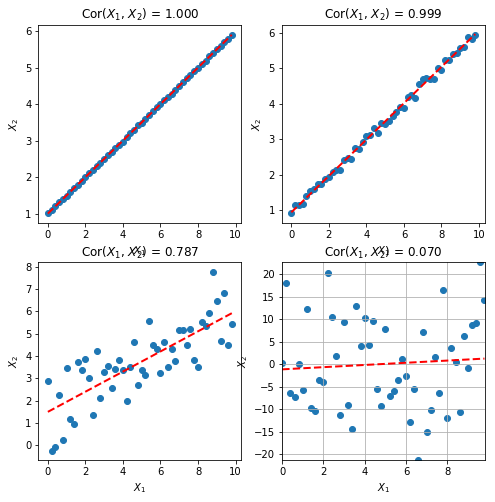

In [6]:
plot_correlation_demo1() # y=0.5x の直線に正規分布に従う確率変数の値を足し，その変動スケールをだんだん大きくしていく

上の図では，最初の3つは高い相関係数をとるためどちらかを捨てられるが，最後の場合は相関が低く，両方を選択する必要がある．  
このような判断はP値を見ても行うことができる．  
<br>
しかし，相関ベースの特徴選択の致命的な欠点は，線形な関連性しか検出できないこと．  
以下のような二次の関連性があるデータの場合はうまく相関係数を得られない．

<Figure size 432x288 with 0 Axes>

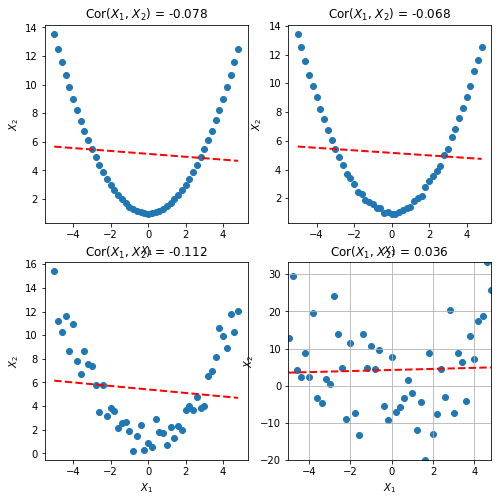

In [7]:
plot_correlation_demo2() # y=0.5x**2 の直線に正規分布に従う確率変数の値を足し，その変動スケールをだんだん大きくしていく

非線形な関連性は，次の相互情報量を用いることで対応できる．

### 相互情報量
一方の特徴量について知っている状態で，もう一方の特徴量を知ることでどれだけの情報が付与されるか？(どれだけ驚くべきことか?)  
<br>
ここで，建物の大きさ，建物の階数，家賃の平均という3つの特徴量からその建物がエレベータ付きであるかどうかを予測する．  
この例では，建物の大きさがわかれば建物の階数は計算で出せそうである．  
しかし，家賃の平均は建物の大きさと関連づけることは難しい．  
よって，家賃の平均と，建物の大きさか建物の階数，を特徴量として用いれば良い．  
<br>
相互情報量は2つの特徴量がどれだけ共通する情報を持つかということをデータの分布から計算する．  
まずは情報エントロピーについて見て行く．  
<br>
公正なコインについて，表と裏の出る確率はそれぞれ50％なので，どちらが出るかについて，その不確かさは最大であると言える．  
この不確かさはシャノンの情報エントロピーにより次のように定義される．
$$ H(X) = - \sum_{i=1}^{n} p(X_i) \log_2 p(X_i) $$
表を$x_0$, 裏を$x_1$とすると，次のように計算できる．
$$ H(X) = - p(x_0) \log_2 p(x_0) - - p(x_1) \log_2 p(x_1) = -0.5 \times -1 - 0.5 \times -1= 1$$

In [11]:
from scipy.stats import entropy
entropy([0.5, 0.5], base=2) # baseのデフォルトは自然対数

1.0

公正なコインでない場合，表が出る確率が60%であるとき，エントロピーは次の値になる．

In [9]:
entropy([0.6, 0.4], base=2)

0.9709505944546688

不確かさが少なくなった．

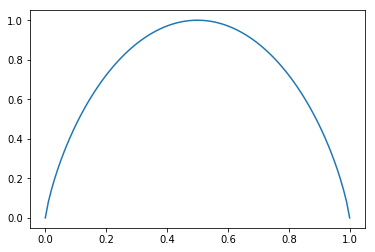

In [20]:
X = np.linspace(0, 1, 100)
Y = entropy([X, 1-X], base=2) 
plt.plot(X, Y)

コインの出る向きの不確かさは，両方の確率が0.5の時に最大になり，どちらかが0％か100%のとき0になる．  
<br>
続いてエントロピーH(X)を，2つの特徴量を対象とするように修正してみる．  
Yという特徴量を知ることで，もう一方の特徴量についての不確かさをどれだけ取り除くかを測定する．  
例えば，天気についての情報が何もなければ，外で雨が降っているかはわからないが，外の芝生が濡れているならば，その不確かさは減る．  
相互情報量は以下の式で表される．  
$$ I(X;Y) = \sum_{i=1}^{m} \sum_{j=1}^{n} P(X_i, Y_j) \log_2 \frac{P(X_i, Y_i)}{P(X_i)P(Y_i)} $$
logの中身はXとYが独立の時1となるため，I(X;Y)=0となる．(最小値)  
また，XとYが完全に同じデータの時，それはXまたはYのエントロピーそのものになる．  
$I(X;Y)=H(X)−H(X∣Y)$が成り立つため，XとYが完全に同じ時$I(X;Y)$は最大値になると言える．  
この時，$I(X;Y)$は「YがわかっているときにXがわかった時，その事象はどれだけXの予測しにくさを取り除いたか」を意味している．  
そして，相互情報量は2つのデータがどれだけ互いに依存しているかの指標になっていると言える．  
[わかりやすい説明](https://mathtrain.jp/mutualinfo)  

相互情報量を[0,1]の区間に正規化するには，ここのエントロピーを合計した値で割る．  
$$ NI(X;Y) = \frac{I(X;Y)}{H(X) + H(Y)} $$
相互情報量は，相関と違って線形の関連性だけで見ない．  

In [21]:
from ch11.demo_mi import plot_mi_demo1, plot_mi_demo2

<Figure size 432x288 with 0 Axes>

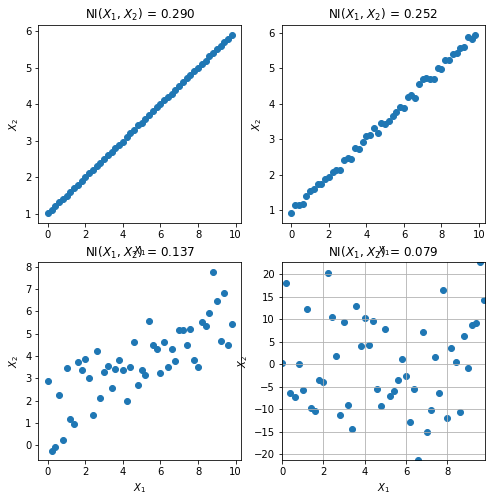

In [22]:
plot_mi_demo1()

<Figure size 432x288 with 0 Axes>

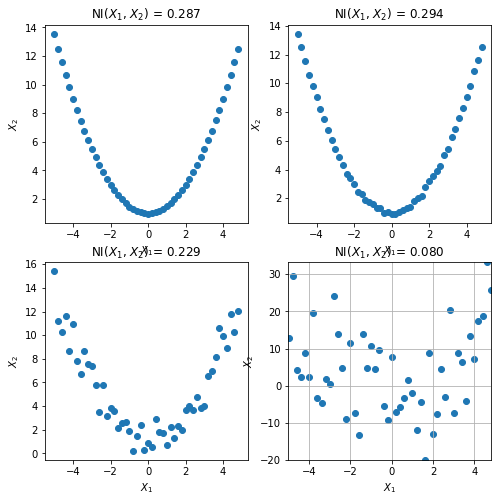

In [23]:
plot_mi_demo2()

次数が変わっても相互情報量に変化が少ないことがわかる．  
<br>
この相互情報量を全ての特徴量のペアについて求め，依存性の高い特徴量はまとめていく．  
しかし，計算量は特徴量の2乗オーダーになり，特徴量の数が多い時には計算量が膨大になってしまう．  
また，依存性の高いペアがみつかり削除されてしまった特徴量が，他の特徴量と合わせることで役に立つことがあるのも欠点である．

## ラッパー法を用いて，特徴量についてモデルに尋ねる
フィルター法で互いに独立な特徴量を得ても，モデルの視点からは無用な特徴量が残っていることがある．  
たとえば，排他的論理和をデータとして見てみる．  

|A|B|Y|
|:--|:--|:--|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

AとBはそれぞれ単体ではYと関連がないが，AとBを合わせることでYとのXORという関連性がわかる．  
そこで，モデル自体に特徴量が有効であるかを投票させるのがラッパー法である．  
1. 全てのデータとラベルをモデルに入れ訓練し，各特徴量の重要度を確認
2. 特徴量を減らせれば，重要でない特徴量を削除する(ランキング下位を削除)
    - 削除できれば1に戻る
    - 十分少なくなったら終了

Scikit-LearnのRFE(Recursive Feature Elimination, 再帰的特徴削減)がラッパー法を行う主力となる手法である．  
RFEは分類器と保持したい特徴量の数をパラメータとしてとる．  
分類器をラッピングし，訓練と特徴量の削減を繰り返す．  
make_classificationによる人工的な分類問題を作成し，効果を確認してみる．

In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [26]:
X, y = make_classification(n_samples=100, n_features=10, n_informative=3, random_state=0)
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
def select_features(clf, n_features_to_select):
    selector = RFE(clf, n_features_to_select=n_features_to_select)
    selector = selector.fit(X, y)
    return selector

In [30]:
selector = select_features(clf, 3)
print(selector.support_)
print(selector.ranking_)

[False False  True False False False  True  True False False]
[5 4 1 2 6 7 1 1 8 3]


n_features_to_selectを変更すると結果がどのように変わるかを見てみる．

In [32]:
for i in range(1, 11):
    selector = select_features(clf, i)
    print(f"n_features_to_select={i}")
    print(selector.support_)
    print(selector.ranking_)
    print()

n_features_to_select=1
[False False False False False False False  True False False]
[ 7  6  3  4  8  9  2  1 10  5]

n_features_to_select=2
[False False False False False False  True  True False False]
[6 5 2 3 7 8 1 1 9 4]

n_features_to_select=3
[False False  True False False False  True  True False False]
[5 4 1 2 6 7 1 1 8 3]

n_features_to_select=4
[False False  True  True False False  True  True False False]
[4 3 1 1 5 6 1 1 7 2]

n_features_to_select=5
[False False  True  True False False  True  True False  True]
[3 2 1 1 4 5 1 1 6 1]

n_features_to_select=6
[False  True  True  True False False  True  True False  True]
[2 1 1 1 3 4 1 1 5 1]

n_features_to_select=7
[ True  True  True  True False False  True  True False  True]
[1 1 1 1 2 3 1 1 4 1]

n_features_to_select=8
[ True  True  True  True  True False  True  True False  True]
[1 1 1 1 1 2 1 1 3 1]

n_features_to_select=9
[ True  True  True  True  True  True  True  True False  True]
[1 1 1 1 1 1 1 1 2 1]

n_features_to_sele

一つ前のやつは選ばれてたけどn増えたら消えてた，ということもなく結果は安定している．

# 他の特徴選択手法
特徴選択手法は，L1ノルムのように学習プロセスに組み込まれていることもある．  
例えば，決定木という手法は，コアとなる部分で特徴選択が行われている．  

# 特徴抽出
無用な特徴量を削除してもまだ特徴量が多すぎるというとき，特徴空間が多すぎることが原因の一つとして考えられる．  
また，3次元や2次元まで特徴量を削減して，データを可視化したい時がある．  
このような場合には，モデルにとってさらに都合の良いように特徴空間を再構成する，特徴抽出手法を利用する．  
線形な特徴抽出手法として主成分分析(principal component analysis, PCA), 非線形な手法として多次元尺度構成法(multi dimensional scaling: MDS)を紹介する．

## 主成分分析(PCA)
特徴量を減らすことに困ったらまずは主成分分析．多くの場合うまくいく．  
PCAは高速で，数学的なため逆変換が可能にもなっている．  
PCAに特徴量の集合を与えると，次の性質を持つ線形な射影を見つける．  
- 変換後の分散が最大になる
- 最終的な再構成誤差(変換後元に戻した時の誤差)が最小化される

PCAで行なった変換の結果は分類や回帰問題の両方に適用することができる．ここでは分類問題を見ていく．

### PCAの概要
PCAは線形代数で学ぶ知識が多く含まれる．ここでは詳細を省略．  
次のステップが基本的なアルゴリズムになる．  
1. 各データから平均値を引き，中心を0にする．  
2. 共分散行列を計算する
3. 共分散行列の固有ベクトルを計算する

N個の特徴量を対象とした場合，変換されたN次元の特徴空間を返す．  
それぞれの特徴量に対応する固有ベクトルを，固有値の大きい順に好きな数だけ採用する．  

### PCAを適用する
まずは人工的なデータセットを用意してみる． 

Text(0, 0.5, 'x2')

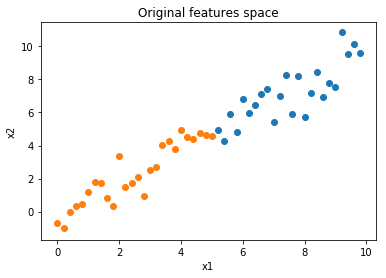

In [35]:
x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(loc=0, scale=1, size=len(x1))
X = np.c_[(x1, x2)] # sample数 * 特徴量数 の二次元配列に結合
good = (x1 > 5) | (x2 > 5) # データの一部をGoodなクラスとする
bad = ~good

plt.scatter(x1[good], x2[good])
plt.scatter(x1[bad], x2[bad])
plt.title("Original features space")
plt.xlabel("x1")
plt.ylabel("x2")

このデータをPCAで2次元から1次元に変換する．  

In [36]:
from sklearn import linear_model, decomposition, datasets

Text(0.5, 0, "X'")

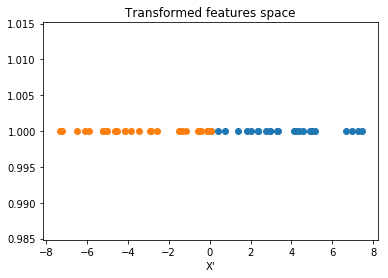

In [41]:
pca = decomposition.PCA(n_components=1)
Xtrans = pca.fit_transform(X) # 変換後の特徴空間に射影, fitメソッドとtransformメソッドの組み合わせ．

plt.scatter(Xtrans[good], np.ones(len(Xtrans[good])))
plt.scatter(Xtrans[bad], np.ones(len(Xtrans[bad])))
plt.title("Transformed features space")
plt.xlabel("X'")

返還後の特徴量は線形に分離が可能なので，これ以上複雑なアルゴリズムは必要ない．  
再構成誤差を知るために，変換されたデータについて変換前から保持している分散の割合を見る．  

In [42]:
pca.explained_variance_ratio_

array([0.979505])

これは，二次元から1次元に変換された後でも分散の96%が保持されているということ．  
<br>
望ましい次元の数を前もって知ることができない場合は，n_componsentsパラメータを指定しないことで，全体の変換を計算させる．  
fittingを行なった後，explained_variance_ratio_は最も大きい分散を持つ基底ベクトルの割合が多い順に配列として格納される．  
この配列をプロットすることで，特徴量の次元がどれだけ必要かについて傾向を把握できる．  
配列の値が大きく減少する直前くらいの次元にすると良い．  
<br>
主成分の分散を各因子に対応させてプロットしたグラフを「Scree plot」という．  
クラス分類問題に対して，Scree plotとグリッドサーチを組み合わせて使ったりする．

## PCAの限界とLDA
PCAは非線形な関連性のデータに対しては限界がある．  
PCAの拡張である「カーネルPCA」という手法では非線形な変換を取り入れており，今まで通りPCAのアプローチを使うことができる．  
PCAはクラス分類問題で次のような弱点がある．

Text(0, 0.5, 'x2')

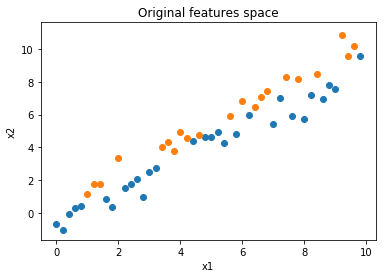

In [43]:
good = x1 > x2
bad = ~good

plt.scatter(x1[good], x2[good])
plt.scatter(x1[bad], x2[bad])
plt.title("Original features space")
plt.xlabel("x1")
plt.ylabel("x2")

このようなデータセットを対象にすると，

Text(0.5, 0, "X'")

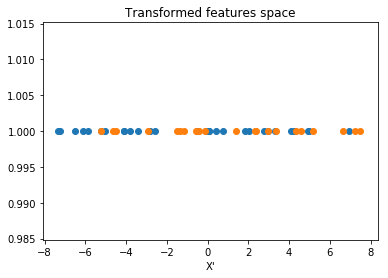

In [45]:
pca = decomposition.PCA(n_components=1)
Xtrans = pca.fit_transform(X) # 変換後の特徴空間に射影, fitメソッドとtransformメソッドの組み合わせ．

plt.scatter(Xtrans[good], np.ones(len(Xtrans[good])))
plt.scatter(Xtrans[bad], np.ones(len(Xtrans[bad])))
plt.title("Transformed features space")
plt.xlabel("X'")

このように，クラス分類しにくい結果になる．  
このデータは，一番大きい分散の軸(x1, 横)方向ではなく，2つ目に大きい分散を持つ軸(x2, 縦)方向に分離している．  
そのため，分散が大きい方に引っ張られる(変換後の分散を最大にしようとする)PCAでは分類しづらい結果になる．  
<br>
この問題に対して，線形判別分析(Linear Discriminant Analysis: LDA)を用いることで解決できる．  
この手法は異なるクラス間のデータポイントの分散を最大化し，クラス内の分散を最小化しようとする，「教師あり」の手法である．

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Text(0.5, 0, "X'")

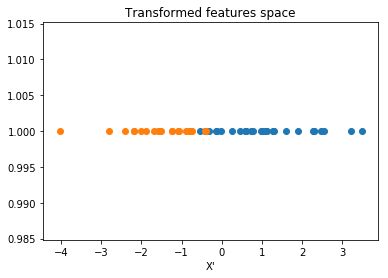

In [52]:
lda_inst = LDA(n_components=1)
Xtrans = lda_inst.fit_transform(X, good) # フィッティングにクラスラベルを利用する，教師ありの手法

plt.scatter(Xtrans[good], np.ones(len(Xtrans[good])))
plt.scatter(Xtrans[bad], np.ones(len(Xtrans[bad])))
plt.title("Transformed features space")
plt.xlabel("X'")

良い感じ  
PCAとLDAのどちらが良いかは状況による．  
クラス数が増え，クラスあたりのサンプルが少なくなるとLDAは機能しにくくなっていく．  
PCAは異なる訓練データ集合に対してLDAほど敏感ではない．  

# 多次元尺度構成法(MDS)
PCAは分散に関する最適化問題を解くことに相当する．  
一方で多次元尺度構成法(MDS)は次元を減らす時にできるだけ相対距離を保つようにする．  
高次元からなるデータセットに対して視覚的な印象を把握したい時に有効．  
MDSはデータ自体についてではなく，データ間の距離，相違性に着目する．  
<br>
MDSでは，まず距離行列を計算する．  
K次元を持つN個のデータポイントに対して，距離関数$d_0$を用いて(主にユークリッド距離),元の特徴空間で距離を計算する．  
<br>
MDSは各データポイントを低次元空間に配置しつつ，低次元空間での新しい距離が元の特徴空間上での距離とできるだけ似るようにする．  
MDSは可視化のためによく用いられるので，低次元空間の次元数は2か3になることが多い．  
<br>
単純なデータセットで具体例を見てみる．

In [54]:
X = np.c_[np.ones(5), 2 * np.ones(5), 10 * np.ones(5)].T
print(X)

[[ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [10. 10. 10. 10. 10.]]


In [55]:
from sklearn import manifold
mds = manifold.MDS(n_components=3)
Xtrans3 = mds.fit_transform(X)

mds = manifold.MDS(n_components=2)
Xtrans2 = mds.fit_transform(X)

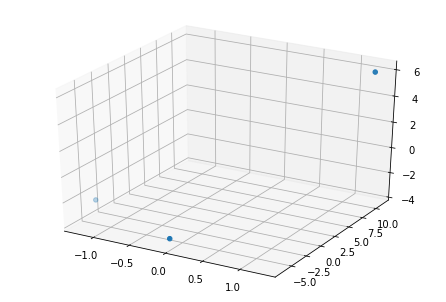

In [65]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*Xtrans3.T)

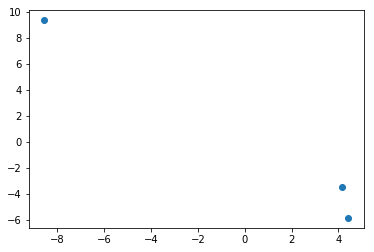

In [68]:
plt.scatter(*Xtrans2.T)

低次元にしても，1点が遠くに，他の2点が近くにある，というように，データ同士の距離をなるべく保ったまま可視化することができる．  
<br>
それでは，少し複雑なアイリスデータセットを見てみる．

In [75]:
from sklearn.datasets import load_iris

data = load_iris()
features = data['data']
target = data['target']
print(features.shape)
print(target.shape)

(150, 4)
(150,)


In [72]:
mds = manifold.MDS(n_components=3)
Xtrans3 = mds.fit_transform(features)

mds = manifold.MDS(n_components=2)
Xtrans2 = mds.fit_transform(features)

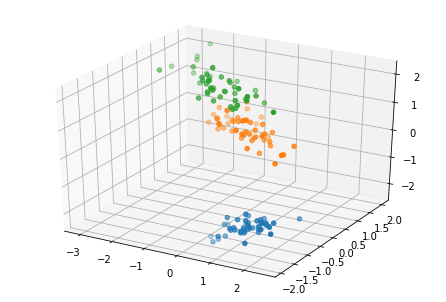

In [78]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*Xtrans3[target == 0].T)
ax.scatter(*Xtrans3[target == 1].T)
ax.scatter(*Xtrans3[target == 2].T)

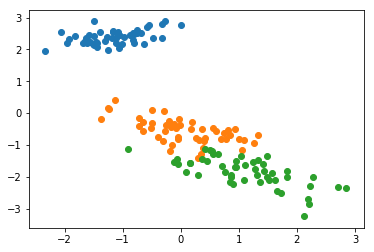

In [81]:
plt.scatter(*Xtrans2[target==0].T)
plt.scatter(*Xtrans2[target==1].T)
plt.scatter(*Xtrans2[target==2].T)

こちらも，距離の小さい花同士は変換後も近くにいることがわかる．

PCAの場合も見てみる．  
こちらは分布の広がりがMDSの場合よりも大きいことがわかる．  

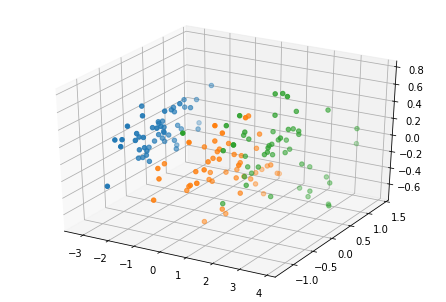

In [84]:
pca = decomposition.PCA(n_components=3)
Xtrans3 = pca.fit_transform(features) 

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*Xtrans3[target == 0].T)
ax.scatter(*Xtrans3[target == 1].T)
ax.scatter(*Xtrans3[target == 2].T)

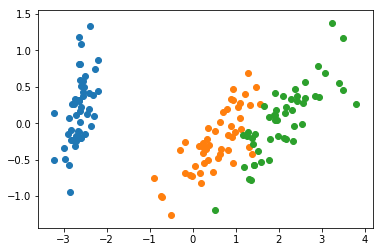

In [85]:
pca = decomposition.PCA(n_components=2)
Xtrans2 = pca.fit_transform(features)

plt.scatter(*Xtrans2[target==0].T)
plt.scatter(*Xtrans2[target==1].T)
plt.scatter(*Xtrans2[target==2].T)

MDSを使うときは，ユークリッド距離を計算できる単位であるかどうかに注意する必要がある．  
MDSデータの類似性を明らかにしてくれる便利なツールである．  
なお，MDSは複数の異なるアルゴリズムの総称である．  
対象とする問題がPCAでもMDSでも歯が立たない場合は，scikit-learnツールキットに用意されている多様体学習アルゴリズムなどが利用できるかもしれない．